In [41]:
# Shap installation 
!pip install --upgrade --quiet shap

In [42]:
# Let's load the dataset

import numpy as np
import pandas as pd 

df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [57]:
# We need to pre-process the data, since the array above contains non-numerical values
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)   
df.head()

x = df.drop(['class'] , axis = 1)
y = df['class']

from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size = 0.25)

# Let's see how pre-processed data look like
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)
print("x_test:\n", x_test, "\n")
print("y_test:\n", y_test, "\n")

x_train shape: (6093, 22) y_train shape: (6093,)
x_test shape: (2031, 22) y_test shape: (2031,)
x_test:
       cap-shape  cap-surface  cap-color  ...  spore-print-color  population  habitat
3684          5            0          3  ...                  1           4        4
4447          2            3          3  ...                  1           5        4
390           0            2          9  ...                  3           3        3
6614          2            2          4  ...                  7           4        2
2913          5            3          2  ...                  2           4        0
...         ...          ...        ...  ...                ...         ...      ...
1252          2            2          8  ...                  3           0        1
2761          5            0          3  ...                  2           5        0
6702          2            3          4  ...                  7           4        0
7571          3            2          2  ... 

In [66]:
# Now let's train some boosting-based model, i. e. XGBoost
# and check how well it performs
import xgboost

model = xgboost.XGBClassifier().fit(x_train, y_train)
print("Model score on test set:", model.score(x_test, y_test))
print("Predictions for the first 3 observations: ", model.predict(x_test[:3]))

Model score on test set: 1.0
Predictions for the first 3 observations:  [1 1 0]


In [64]:
# Suspiciously high accuracy, or a simple dataset - 
# NN-based model from HW1 reached similar accuracy
#
# Time to import shap and calculate values of interest.
import shap

explainer = shap.Explainer(model, x_test)
shap_values = explainer(x_test)

# We should explore our results a bit before an in-depth look into selected observations
print("shap_values.shape:", shap_values.shape)
print("shap values for the first 3 observations:\n", shap_values[:3])

shap_values.shape: (2031, 22)
shap values for the first 3 observations:
 .values =
array([[-2.25128297e-02, -7.79283717e-03, -7.49672402e-03,
         0.00000000e+00,  4.36389297e+00,  0.00000000e+00,
         5.75345284e-01, -2.35958197e-01,  5.84225780e-01,
         4.90195824e-02,  5.78780794e-01,  9.92087920e-01,
        -1.74860364e-02, -6.12291995e-02, -1.69472100e-01,
         0.00000000e+00,  0.00000000e+00,  2.50572840e-02,
         1.95320427e-03,  2.52994233e-01,  2.77550748e-01,
        -2.83240965e-02],
       [ 2.28680402e-02,  4.58402187e-04, -7.49672402e-03,
         0.00000000e+00,  4.44459180e+00,  0.00000000e+00,
         5.59240679e-01, -2.40083815e-01,  5.84225780e-01,
         4.90195824e-02,  5.78780794e-01,  1.07589699e+00,
         1.66273589e-02, -6.12291995e-02,  3.25869619e-01,
         0.00000000e+00,  0.00000000e+00,  2.50572840e-02,
         1.95320427e-03,  2.29988051e-01,  5.93863249e-02,
        -2.97848125e-02],
       [ 2.05821967e-01,  6.87603205e-0

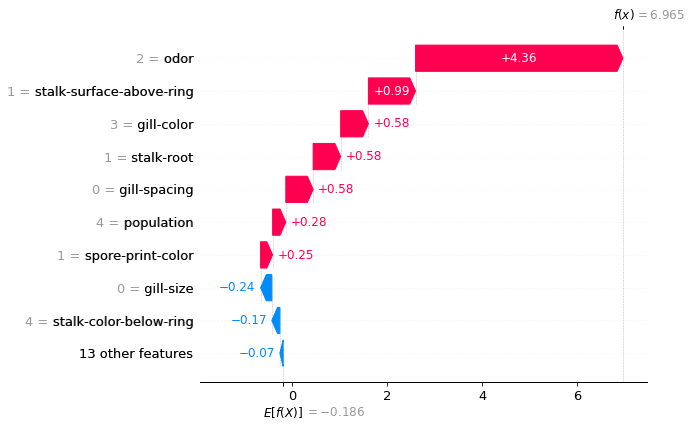

In [73]:
# Let's put the above into perspective and do some waterfall plots
shap.plots.waterfall(shap_values[0])

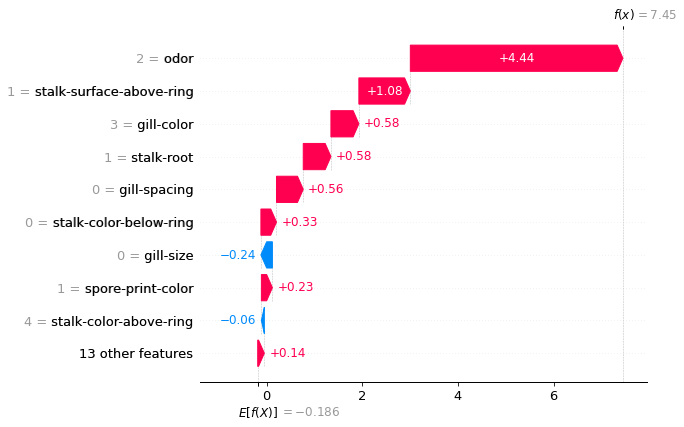

In [74]:
shap.plots.waterfall(shap_values[1])

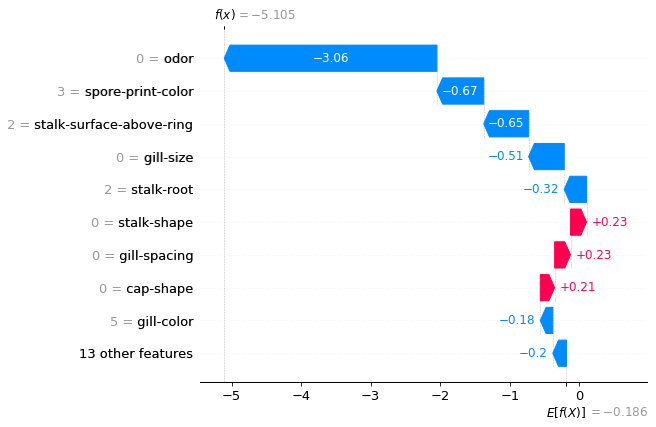

In [75]:
shap.plots.waterfall(shap_values[2])

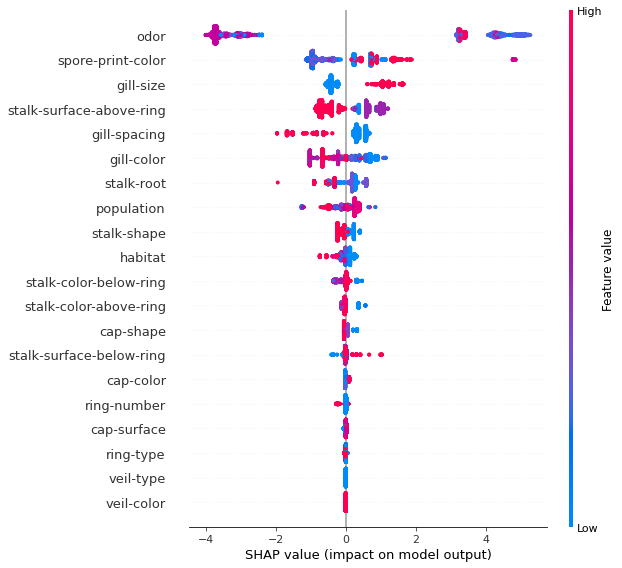

In [79]:
#As we can see, in all of the above odor had the highest impact.
#Also, notice that in the first two observations it affected output positively, and in third - negatively. 
#
#Let's see more general plot:

shap.summary_plot(shap_values, x_test)

In [100]:
# Seems that although odor had the greatest impact most of the time, 
# we might be able to find few observations where spore-print-color turned out to be critical

vals = [np.max(abs(shap_value.values)) for shap_value in shap_values]
importance = [np.argmax(abs(shap_value.values)) for shap_value in shap_values]
print(vals)
print(importance)

[4.363892969321459, 4.444591798167676, 3.056340482253581, 3.402345745675266, 3.6290349459461866, 3.056340482253581, 3.7456247889064254, 2.7145345177128912, 3.228483421318233, 3.4077955391816794, 3.766980491857976, 4.442253419365734, 4.34218815362081, 3.6290349459461866, 4.160461540687829, 3.7141004028357565, 3.310611037388444, 3.4990517962537706, 4.272168713752181, 3.437991996649653, 3.38835659371689, 3.665730043966323, 3.203954418040812, 3.2456323847547175, 4.7357132735475895, 3.7257417318411172, 3.228483421318233, 3.7141004028357565, 3.816847493816167, 3.228483421318233, 3.3809900427237154, 3.4780982874892654, 3.7102641762979327, 2.8323183869570494, 3.3433209899812937, 3.228483421318233, 3.6290349459461866, 3.3809900427237154, 3.203954418040812, 3.6614792886190117, 3.381728630568832, 3.635075251031667, 3.203954418040812, 3.6076792429946365, 3.635075251031667, 3.785441461466253, 3.7043860288895667, 3.752705701533705, 4.171275145802647, 3.228483421318233, 3.228483421318233, 4.790200439

In [105]:
# As expected, importance list (filled with the highest shapley values) is almost filled with 4's (odor)
# Perhaps we'll find index with a different leading feature?

i = 0
for x in importance:
  if x !=4:
    break
  i += 1
print(i)

75


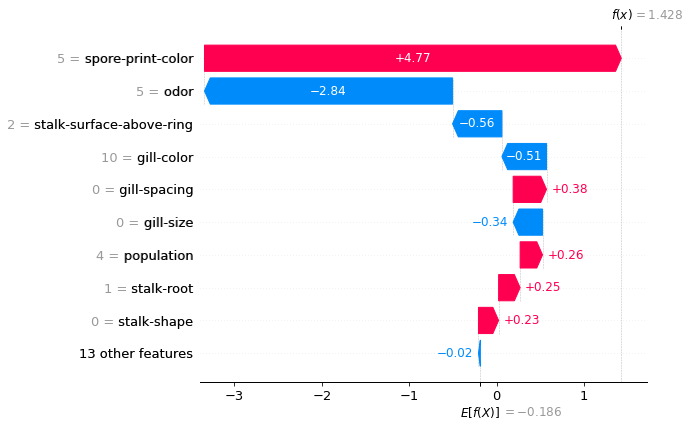

In [106]:
# And there it is - one, where something different than smell was critical.

shap.plots.waterfall(shap_values[75])

In [107]:
# And now, for the last point, let's re-use some code from HW1 to train simple NN classifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("mushrooms.csv")
encoder = OneHotEncoder(drop='first', dtype=int)

y = df.loc[:,'class'].values
X = df.drop(['class'], axis=1)

y = encoder.fit_transform(y.reshape(-1, 1)).todense()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
325/325 [==============================] - 3s 3ms/step - loss: 0.6770 - accuracy: 0.5809 - val_loss: 0.5105 - val_accuracy: 0.9308
Epoch 2/10
325/325 [==============================] - 1s 2ms/step - loss: 0.4838 - accuracy: 0.8629 - val_loss: 0.2708 - val_accuracy: 0.9446
Epoch 3/10
325/325 [==============================] - 1s 2ms/step - loss: 0.2703 - accuracy: 0.9264 - val_loss: 0.1382 - val_accuracy: 0.9685
Epoch 4/10
325/325 [==============================] - 1s 2ms/step - loss: 0.1545 - accuracy: 0.9608 - val_loss: 0.0842 - val_accuracy: 0.9738
Epoch 5/10
325/325 [==============================] - 1s 2ms/step - loss: 0.1039 - accuracy: 0.9721 - val_loss: 0.0600 - val_accuracy: 0.9769
Epoch 6/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0704 - accuracy: 0.9816 - val_loss: 0.0444 - val_accuracy: 0.9846
Epoch 7/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0488 - accuracy: 0.9905 - val_loss: 0.0346 - val_accuracy: 0.9915
Epoch 

In [113]:
# X_test.shape

(1625, 95)

In [117]:
# def f(X):
#     return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [ ]:
# explainer = shap.KernelExplainer(f, X.iloc[:50,:])
# shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)
# shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

In [125]:
# Back to shapley values

#background = X_test[np.random.choice(X.shape[0],100, replace=False)]
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

print("shap_values.shape:", shap_values.shape)
print("shap values for the first 3 observations:\n", shap_values[:3])

Exception: ignored

And with that unsuccesful attempt we've reached the end - second model was trained correctly, but I couldn't get SHAP library to work with it, despite multiple attempts and different explainers tried.